In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime
import glob

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

# Model Output

In [2]:
timestep = 1  # time resolution, 1, 6, or 24 hr
resolution = 1  # resolution of DEM, 1 or 5 m
lasttime = 518400  # output time stamp to plot
cut = 100  # point on x axis to plot cross section of DEM (resolution dependent)
name = 'rain{}hr_{}m_30cmBedrock_k10-2'.format(timestep, resolution)

In [3]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/sedoutput.dat'.format(name)
seds_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
seds_['Qw(actual)'] = seds_['Qw(actual)'] * 60 * 60
density = 1330
rock = 2660
seds_['SSC'] = seds_['Suspended'] * density / seds_['Qw(actual)']
seds_['Bedload'] = (seds_['Sand'] + seds_['Gravel']) * rock / seds_['Qw(actual)']

In [4]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/input_data/rainfall_max{}hr_365days.txt'.format(name, timestep)
rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
seds_all = pd.concat([seds_, rain], axis=1, sort=False).dropna()

In [5]:
date_rng = pd.date_range(start='4/12/2016 02:00:00', periods=len(seds_all), freq='{}H'.format(timestep))
seds_all['date'] = date_rng[:len(seds_all)]
seds_all = seds_all.set_index('date', drop=False)

<Figure size 1080x1080 with 0 Axes>

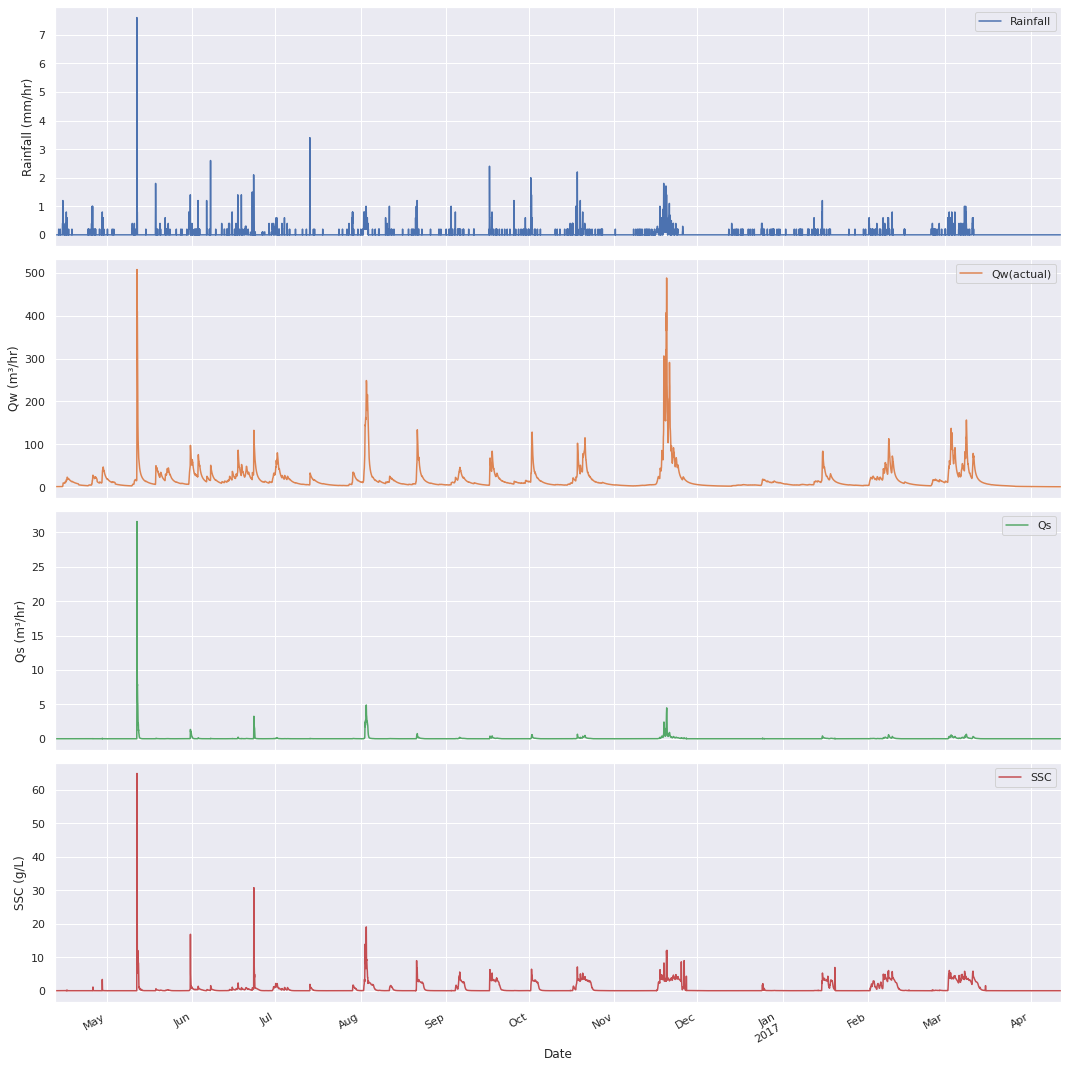

In [6]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'SSC']
cols_label = ['Rainfall (mm/hr)', 'Qw (m³/hr)', 'Qs (m³/hr)', 'SSC (g/L)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Observation

In [7]:
file = '/work/armitagj/Documents/MPH03001-benchmark/stage/all-data/Données-début/waterFlux-ssc-2016.csv'
df = pd.read_csv(file)
df['DateDebit'] = pd.to_datetime(df['Date'], format='%d/%m/%y %H:%M')
df = df.drop(columns=['Date', 'JOUR', 'HEURE', 'DATE', 'Unnamed: 3', 'Unnamed: 7'])
df = df.dropna()

In [8]:
files = glob.glob('/work/armitagj/Documents/MPH03001-benchmark/stage/all-data/Données-début/Données brutes/PLUVIO_POMMEROY/DATA_BRUTE/*.xlsx')
for i, file in enumerate(files):
    dfs = pd.read_excel(file, skiprows=6, engine='openpyxl').dropna()
    if 'JOUR' in dfs.columns:
        dfs['day'] = dfs['JOUR'].map(lambda x: str(x).rstrip('00:00:00'))
        dfs['hour'] = dfs['HEURE'].map(lambda x: str(x))
        dfs['rain'] = dfs['PLUIES (mm)'].map(lambda x: float(str(x).replace(',','.')))
        dfs['date'] = pd.to_datetime(dfs['day'] + ' ' + dfs['hour'], format='%Y-%m-%d  %H:%M:%S')
        if i == 0:
            rainfall = dfs
        else:
            rainfall = pd.concat([rainfall, dfs])
    else:
        dfs = pd.read_excel(file, engine='openpyxl').dropna()
        if 'JOUR' in dfs.columns:
            dfs['day'] = dfs['JOUR'].map(lambda x: str(x).rstrip('00:00:00'))
            dfs['hour'] = dfs['HEURE'].map(lambda x: str(x))
            dfs['rain'] = dfs['PLUIES (mm)'].map(lambda x: float(str(x).replace(',','.')))
            dfs['date'] = pd.to_datetime(dfs['day'] + ' ' + dfs['hour'], format='%Y-%m-%d  %H:%M:%S')
            if i == 0:
                rainfall = dfs
            else:
                rainfall = pd.concat([rainfall, dfs])

In [9]:
def timeconv(df, times):
    time = df[times].values
    hours = np.floor(time/60)
    minutes = time - hours*60
    timeOfDay = []
    for i in range(len(df)):
        timeOfDay.append('{:02d}:{:02d}:00'.format(np.int(hours[i]), np.int(minutes[i])))
    return timeOfDay

def yearconv(df, day, month, year):
    day = df[day].values
    month = df[month].values
    year = df[year].values
    date = []
    for i in range(len(df)):
        date.append('{:02d}/{:02d}/{:02d}'.format(np.int(day[i]), np.int(month[i]), np.int(year[i])))
    return date

In [10]:
files = glob.glob('/work/armitagj/Documents/MPH03001-benchmark/stage/all-data/Données-début/Pluies_meteo_fr/*.xlsx')
files_select = [files[2], files[3]]

In [11]:
dfn = pd.read_excel(files_select[0], skiprows=10, names=['year', 'month', 'day', 'time', 'rain', 'empty', 'na'], engine='openpyxl').drop(columns=['empty', 'na']).dropna()
dfn['timeOfDay'] = timeconv(dfn, 'time')
dfn['date'] = yearconv(dfn, 'day', 'month', 'year')
dfn['date'] = pd.to_datetime(dfn['date'] + ' ' + dfn['timeOfDay'], format='%d/%m/%y %H:%M:%S')
rainfall = pd.concat([rainfall, dfn])
rainfall_fill = dfn

In [12]:
dfn = pd.read_excel(files_select[1], skiprows=10, names=['year', 'month', 'day', 'time', 'rain', 'empty', 'n1', 'n2', 'n3', 'n4'], engine='openpyxl').drop(columns=['empty', 'n1', 'n2', 'n3', 'n4']).dropna()
dfn['timeOfDay'] = timeconv(dfn, 'time')
dfn['date'] = yearconv(dfn, 'day', 'month', 'year')
dfn['date'] = pd.to_datetime(dfn['date'] + ' ' + dfn['timeOfDay'], format='%d/%m/%y %H:%M:%S')
rainfall = pd.concat([rainfall, dfn])
rainfall_fill = pd.concat([rainfall_fill, dfn])

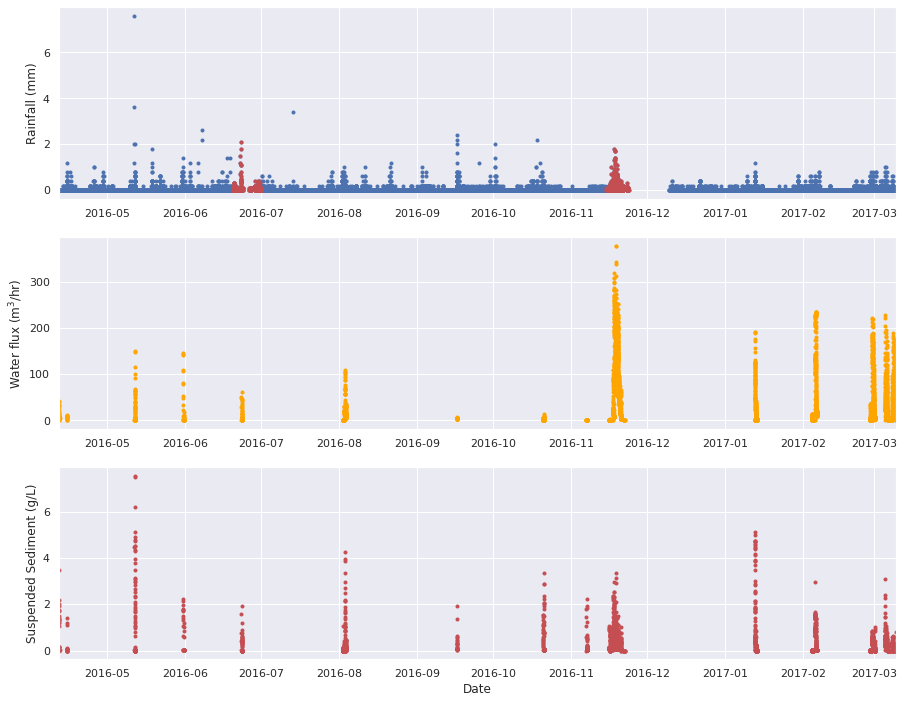

In [13]:
sns.set(rc={'figure.figsize':(15, 12)})
plt.figure()
plt.subplot(3,1,1)
plt.plot(rainfall['date'], rainfall['rain'], '.b')
plt.plot(rainfall_fill['date'], rainfall_fill['rain'], '.r')
plt.ylabel('Rainfall (mm)')
plt.xlim(df['DateDebit'].min(), df['DateDebit'].max())
plt.subplot(3,1,2)
plt.plot(df['DateDebit'], df['Débit m3/h'], '.', color='orange')
plt.ylabel('Water flux (m$^{3}$/hr)')
plt.xlim(df['DateDebit'].min(), df['DateDebit'].max())
plt.subplot(3,1,3)
plt.plot(df['DateDebit'], df['MES g/L'], '.r')
plt.ylabel('Suspended Sediment (g/L)')
plt.xlabel('Date')
plt.xlim(df['DateDebit'].min(), df['DateDebit'].max())
plt.tight_layout
plt.show()

# Compare

In [14]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/Elevations{}.asc'.format(name, lasttime)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)

# the matrix gets fliped when I read it (180° rotation)
z = np.flip(np.flip(data_array, 1), 0)
x,y = np.meshgrid(xcorner, ycorner)

ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/results/Elevations{}.asc'.format(name, 0)
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
# the matrix gets fliped when I read it (180° rotation)
zstart = np.flip(np.flip(data_array, 1), 0)

In [15]:
datemin = '2016-08-15 02:00:00'
datemin = datetime.datetime.strptime(datemin, '%Y-%m-%d %H:%M:%S')
datemax = df['DateDebit'].max()

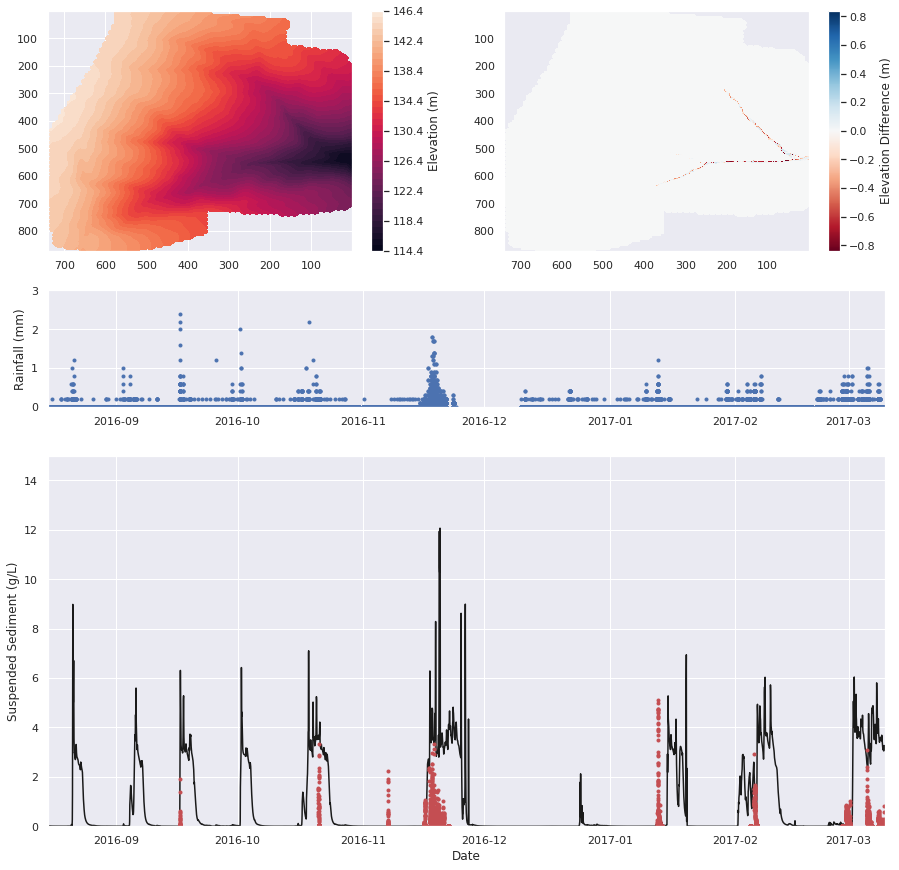

In [16]:
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
plt.subplot(3, 2, 1)
plt.contourf(x, y, z, 50)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())

plt.subplot(3, 2, 2)
clim = np.nanmax(np.abs(z-zstart))
plt.pcolormesh(x, y, z-zstart, cmap='RdBu', vmin=-clim, vmax=clim)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation Difference (m)')
plt.xlim(x.max(), x.min())
plt.ylim(y.max(), y.min())

plt.subplot(6, 1, 3)
plt.plot(rainfall['date'], rainfall['rain'], '.b')
plt.plot(rainfall_fill['date'], rainfall_fill['rain'], '.b')
plt.ylabel('Rainfall (mm)')
plt.xlim(datemin, datemax)
plt.ylim(0, 3)

plt.subplot(2, 1, 2)
plt.plot(seds_all['date'], seds_all['SSC'], 'k')
plt.plot(df['DateDebit'], df['MES g/L'], '.r')
plt.ylabel('Suspended Sediment (g/L)')
plt.xlabel('Date')
plt.xlim(datemin, datemax)
plt.ylim(0, 15)
plt.tight_layout
plt.savefig('Canche-micro-catchment-comparison.png', dpi=300)
plt.show()

# Output the observations for calibaration

In [33]:
df.to_pickle('EGU2022/Pommeroy-observations.pkl')
rainfall.to_pickle('EGU2022/Pommeroy-rainfall.pkl')
rainfall_fill.to_pickle('EGU2022/Pommeroy-rainfall-fill.pkl')